# Interfacing with scikit-learn

The `ScikitLearnNode` allows you to use any model from the scikit-learn library as a regular offline readout node (similar to the Ridge node). As scikit-learn implements most major methods for classification and regression, you can easily implement and experiment different methods in your ReservoirPy models.

In the following tutorial, you will learn how to use the `ScikitLearnNode` on both regression and classification tasks.

For more information about scikit-learn models, please visit the [API reference](https://scikit-learn.org/stable/modules/classes.html).

## Summary

- <a href="#chapter1">Chapter 1: `ScikitLearnNode` basic usage</a>
- <a href="#chapter2">Chapter 2: Using `ScikitLearnNode` for classification</a>
- <a href="#chapter3">Chapter 3: Automatic Ridge parameter search with `RidgeCV`</a>


In [ ]:
%pip install reservoirpy[sklearn]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy
from reservoirpy.observables import nrmse, rsquare
reservoirpy.set_seed(42)

## Chapter 1: `ScikitLearnNode` basic usage <span id="chapter1"/>

### Instantiate a node

To create a node, simply instantiate a `ScikitLearnNode` by passing the model class as an argument. Here, we will use [Lasso Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

You can use any model that implements the `.fit` and `.predict` methods !

In [2]:
from sklearn import linear_model

from reservoirpy.nodes import ScikitLearnNode

readout = ScikitLearnNode(linear_model.Lasso)

If you want to specify parameters to the model, you can directly pass them as parameters to the Node.

In [3]:
readout = ScikitLearnNode(
    model = linear_model.Lasso, 
    alpha = 1e-3,
    name = "Lasso"
)

### Node usage

The `ScikitLearnNode` follows the same syntax as any other offline readout nodes : you can call the `.fit` method to train its parameters, and `.run` to get predictions !

Under the hood, ReservoirPy handles the respective calls to the model's `.fit` and `.predict` methods.

Let's test our model on the Mackey-Glass task seen in the previous tutorials. 

In [4]:
# create the model
reservoir = reservoirpy.nodes.Reservoir(
    units = 500,
    lr = 0.3,
    sr = 0.9,
)

model = reservoir >> readout

In [5]:
# create the dataset to train our model on
from reservoirpy.datasets import mackey_glass, to_forecasting

mg = mackey_glass(n_timesteps=10_000, tau=17)
# rescale between -1 and 1
mg = 2 * (mg - mg.min()) / np.ptp(mg) - 1

X_train, X_test, y_train, y_test = to_forecasting(mg, forecast=10, test_size=0.2)

In [6]:
model.fit(X_train, y_train, warmup=100)

/home/paul/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e+00, tolerance: 1.921e-01
  model = cd_fast.enet_coordinate_descent(


### Evaluate the model

In [7]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [8]:
y_pred = model.run(X_test)

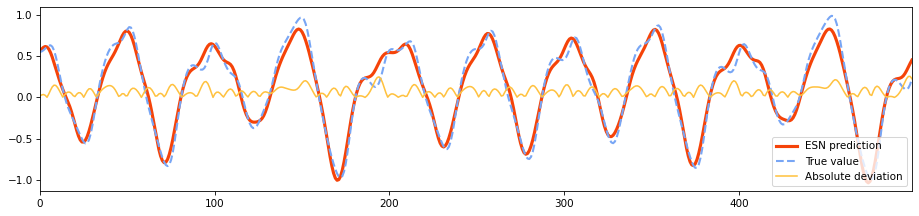

(np.float64(0.9679528294199475), np.float64(0.043875437566613905))

In [9]:
plot_results(y_pred, y_test)
rsquare(y_test, y_pred), nrmse(y_test, y_pred)

### Node internals

The instance of the scikit-learn model can be accessed using its `instances` param.

In [10]:
node = ScikitLearnNode(linear_model.PassiveAggressiveRegressor)
node.initialize(x=np.ones((10, 3)), y=np.ones((10, 1)))
str(node.instances)

'PassiveAggressiveRegressor(random_state=RandomState(MT19937) at 0x7F26242B5E40)'

Most scikit-learn models only handles one output feature. In that case, multiple instances of the model are created under the hood, and each output features are dispatched among the models. And `node.instances` is a list containing the model instances.

In [11]:
node = ScikitLearnNode(linear_model.PassiveAggressiveRegressor)
# we now have 2 output features !
node.initialize(x=np.ones((10, 3)), y=np.ones((10, 2)))
node.instances

[PassiveAggressiveRegressor(random_state=RandomState(MT19937) at 0x7F26242B5F40),
 PassiveAggressiveRegressor(random_state=RandomState(MT19937) at 0x7F26242B6A40)]

## Chapter 2: Using `ScikitLearnNode` for classification <span id="chapter2"/>

In the previous tutorial, we have seen a trick to handle a classification task only using ridge regression, with the `Ridge` node.

Although the results were pretty satisfying, regressions methods are not designed for classification tasks. One issue is that outlier data can significantly shift the decision boundary, as described and illustrated [here](https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression).

Fortunately, `scikit-learn` implements many different classifiers, such as `RidgeClassifier`, `LogisticRegression` or `Perceptron`. Let's try them !

In this chapter, we will take the same dataset as in Tutorial 5. You can check it to get some data visualization.

In [12]:
import numpy as np
from reservoirpy.datasets import japanese_vowels

# repeat_target ensure that we obtain one label per timestep, and not one label per utterance.
X_train, X_test, Y_train, Y_test = japanese_vowels(repeat_targets=True)

# Y_train and Y_test are one-hot encoded, but we want qualitative values here.
Y_train = [np.argmax(sample, 1, keepdims=True) for sample in Y_train]
Y_test = [np.argmax(sample, 1, keepdims=True) for sample in Y_test]

X_train[0].shape, Y_train[0].shape

((20, 12), (20, 1))

In [13]:
from reservoirpy.nodes import Reservoir, ScikitLearnNode
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron

reservoir = Reservoir(500, sr=0.9, lr=0.1)
sk_ridge = ScikitLearnNode(RidgeClassifier, name="RidgeClassifier")
sk_logistic = ScikitLearnNode(LogisticRegression, name="LogisticRegression")
sk_perceptron = ScikitLearnNode(Perceptron, name="Perceptron")

# One reservoir for 3 readout. That's the magic of reservoir computing!
model = reservoir >> [sk_ridge, sk_logistic, sk_perceptron]

In [14]:
model.fit(X_train, {"RidgeClassifier": Y_train, "LogisticRegression": Y_train, "Perceptron": Y_train}, warmup=2)
Y_pred = model.run(X_test)

/home/paul/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paul/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paul/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1307: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
from sklearn.metrics import accuracy_score

speaker = np.concatenate(Y_test, dtype=np.float64)

for model, pred in Y_pred.items():
    model_pred = np.concatenate(pred)
    score = accuracy_score(speaker, model_pred)
    print(f"{model} score: {score * 100:.3f} %")

LogisticRegression score: 93.564 %
RidgeClassifier score: 94.848 %
Perceptron score: 91.243 %


## Chapter 3: Automatic Ridge parameter search with `RidgeCV` <span id="chapter3"/>

Finding the right hyper-parameters for your model in reservoir computing is often a significant part of the research.
In the fourth tutorial, we have seen how we can explore the hyperparameter space

In reservoir computing, we usually train the readout layer using ridge regression as a strategy to avoid overfitting on
the reservoir states. Finding the right regularization level plays an important role in optimizing your model, and this 
parameter is usually tuned alongside the reservoir hyperparameters, such as the leak rate or the spectral radius.

However, the reservoir activity doesn't depend on the regularization parameter, and can be tuned independently. Once the
reservoir states over time have been generated, we can test multiple regularizations to choose which ones fits best.

That's where the [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) model 
comes in handy: it can evaluate multiple regularizations at once during fitting time, using a cross-validation, and pick
the best one.

In [16]:
# Dataset definition
import numpy as np
from reservoirpy.datasets import lorenz, to_forecasting

mg = lorenz(n_timesteps=5_000)
mg = 2 * (mg - mg.min()) / np.ptp(mg) - 1  # rescale between -1 and 1
X_train, X_test, y_train, y_test = to_forecasting(mg, forecast=10, test_size=0.2)

In [17]:
from sklearn.linear_model import RidgeCV
from reservoirpy.nodes import Ridge, Reservoir, ScikitLearnNode

# create the model
reservoir = Reservoir(units=500, lr=0.3, sr=0.9, seed=2504)

# here, we try 5 different regularization parameters
readout = ScikitLearnNode(
    model=RidgeCV,
    alphas = [1e-8, 1e-6, 1e-4, 1e-2, 1],
)
model = reservoir >> readout

# scikit-learn's model will evaluate all five parameters using cross-validation
model.fit(X_train, y_train)

# Selected ridge value
print(f"Best ridge: {readout.instances.alpha_}")

Best ridge: 1e-06


### Comparing execution time in parameter exploration

In [18]:
import time
from reservoirpy.observables import nrmse

ridges = [1e-8, 1e-6, 1e-4, 1e-2, 1]

# Iterating over ridges

start = time.time()
best_loss = np.inf
best_ridge = ()
for ridge in ridges:
    reservoir = Reservoir(units=500, lr=0.3, sr=0.9, seed=2504)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout
    y_pred = model.fit(X_train, y_train).run(X_test)
    loss = nrmse(y_true=y_test, y_pred=y_pred)
    if loss < best_loss:
        best_ridge = ridge
        best_loss = loss
end = time.time()
print(best_loss)
print(f"Loop: Best ridge: {best_ridge}. Found in {end - start:.3}s")

# RidgeCV method

start = time.time()
reservoir = Reservoir(units=500, lr=0.3, sr=0.9, seed=2504)
readout = ScikitLearnNode(model=RidgeCV, alphas=ridges)
model = reservoir >> readout
model.fit(X_train, y_train)
best_ridge = readout.instances.alpha_

y_pred = model.run(X_test)
loss = nrmse(y_true=y_test, y_pred=y_pred)
print(loss)

end = time.time()
print(f"RidgeCV: Best ridge: {best_ridge}. Found in {end - start:.3}s")

0.0663115287271107
Loop: Best ridge: 1e-06. Found in 1.72s
0.06631154000336253
RidgeCV: Best ridge: 1e-06. Found in 0.756s


In this situation, we obtained a x3.5 performance gain for similar results. This illustrates the importance of RidgeCV in hyperparameter exploration.